In [1]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import math
import random
import copy
from PSO import PSO

In [2]:
base = "/Users/yashodeepmahapatra/Desktop/Text-Mining-1/bbcsport/"
os.chdir(base)
folders = os.listdir()
texts = []
for folder in folders:
    os.chdir(os.path.join(base, folder))
    files = os.listdir()
    for file in files:
        with open(file, 'rb') as curr_file:
            texts.append(str(curr_file.read()).lstrip("b\'").rstrip("b\'"))
# print(texts)
tfidf_vectorizer = TfidfVectorizer(texts, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(texts)
words = tfidf_vectorizer.get_feature_names()
vectors = tfidf.todense()
svd = TruncatedSVD(n_components = 3)
vectors_svd = svd.fit_transform(vectors)
vectors_svd = Normalizer().fit_transform(vectors_svd)
# print(vectors_svd.shape)
# fig=plt.figure()
# ax = Axes3D(fig)
# X = vectors_svd
# print(X)
# for j in range(len(X)):
#     ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
#     ax.view_init(330, 120)

/Users/yashodeepmahapatra/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Iteration #0....
Updated particle best...
Updated particle best...
Iteration #1....
/Users/yashodeepmahapatra/anaconda/lib/python3.6/site-packages/sklearn/decomposition/truncated_svd.py:187: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
Updated particle best...
Updated particle best...
Updated particle best...
Iteration #2....
Updated particle best...
Updated particle best...
Iteration #3....
Updated particle best...
Iteration #4....
Iteration #5....
Iteration #6....
Iteration #7....
Iteration #8....
Iteration #9....
Iteration #10....
Updated particle best...
Iteration #11....
Iteration #12....
Iteration #13....
Iteration #14....
Updated particle best...
Iteration #15....
Iteration #16....
Iteration #17....
Iteration #18....
Iteration #19....
Iteration #20....
Iteration #21....
Iteration #22....
Iteration #23....
Iteration #24....
Iteration #25....
Iteration #26....
Iteration #27....
Iteration #28....
Iteration #29....
Up

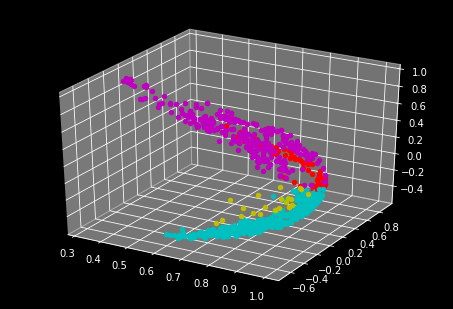

In [5]:
p1 = PSO(vectors_svd, num_clusters = 5, num_particles = 10, iterations = 100)
p1.converge(w1 = 0.9, w2 = 0.9, c1 = 0.5, c2 = 1.5)